# Проект - Credit Scoring

Первая и самая важная цель банка — заработать деньги. Если банк будет вести слишком жесткую политику, не выдавая кредиты даже тем, кто вернул бы деньги, то он не заработает на процентах. Отказ в кредите хорошему заемщику — ошибка первого рода. Риск, с которым сталкивается кредитная организация — дать кредит неблагонадёжному заёмщику, который впоследствии может допустить дефолт, а банк потеряет деньги — ошибка второго рода.
	
Чтобы соблюсти баланс, используется кредитный скоринг, который позволяет спрогнозировать вероятность невозврата кредита. Клиентов, обратившихся за кредитом, сортируют по этой предсказанной вероятности (по убыванию), и получается скоркарта — рейтинг клиентов от плохих к хорошим. 

Используя данные о клиенте, работник банка может решить, выдавать ли клиенту кредит, и если да, то под какой процент.

При этом используемый в кредитном скоринге алгоритм позволяет предсказывать значения непрерывной зависимой переменной на интервале от  до . Банки самостоятельно определяют для себя значения, при которых они принимают решение об отказе в кредите.

Цель проекта - выбрать наиболее эффективную модель оценки качества клиентов банка.

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from catboost import CatBoost, CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
import lightgbm
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

%matplotlib inline

# settings to display all columns
pd.set_option("display.max_columns", None)

RANDOM_SEED = 42

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# dir_data = './drive/MyDrive/Stud/SkillFactory/Unit_5/project_5/'

In [2]:
def boxplot(col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=col, data=data[data['sample']==1], ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()
    
    
def age_to_cat(age):
    if age <= 28:
        cat_age = 'young'
        return cat_age             
    if 28 < age <= 35:
        cat_age = 'not-young'
        return cat_age
    if 35 < age <= 50:
        cat_age = 'midle'
        return cat_age
    if age > 50:
        cat_age = 'mature'
        return cat_age
    
    

In [3]:
# path = '/kaggle/input/sf-dst-scoring/'

In [4]:
# train = pd.read_csv(path +'train.csv')
# test = pd.read_csv(path +'test.csv')
# sample = pd.read_csv(path +'sample_submission.csv')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

# train = pd.read_csv(dir_data+'train.csv')
# test = pd.read_csv(dir_data+'test.csv')
# sample = pd.read_csv(dir_data+'sample_submission.csv')

In [5]:
# profile = train.profile_report()
# profile.to_file('data_report.html')

In [6]:
print(train.info())
print()
print('Train size: ', train.shape)
print()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
print(test.info())
print()
print('Test size: ', test.shape)
print()
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [8]:
print(sample.info())
print()
print('Sample size: ', sample.shape)
print()
sample.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
None

Sample size:  (24354, 2)



,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


## Описания полей
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов клиента в БКИ о своей кредитной истории
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

<AxesSubplot:>

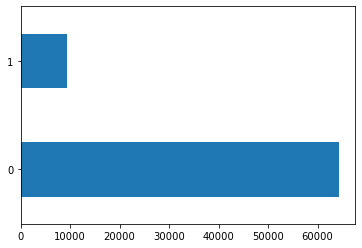

In [9]:
# посмотрим на целевую переменную
train['default'].value_counts().plot.barh()

Note: Выборка несбалансированная.

In [10]:
# объединим датасеты для удобства предварительной обработки
train['sample'] = 1   # train
test['sample'] = 0    # test
test['default'] = -1

data = pd.concat([train, test], ignore_index=True)

# num of unique values, first 10 unique values, null values count, type
data_agg = data.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))\
    .transpose()

data_agg

,<lambda>,nunique,null,dtype
client_id,"[25905, 63161, 25887, 16222, 101655, 41415, 28...",110148,0,int64
app_date,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",120,0,object
education,"[SCH, GRD, UGR, PGR, ACD, nan]",5,478,object
sex,"[M, F]",2,0,object
age,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29]",52,0,int64
car,"[Y, N]",2,0,object
car_type,"[Y, N]",2,0,object
decline_app_cnt,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9]",24,0,int64
good_work,"[0, 1]",2,0,int64
score_bki,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",102618,0,float64


In [11]:
print(data.info())
print()
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## EDA

* В наборе даных 19 признаков
* Всего представлено 110 148 клиентоа
* Количество пропусков 0.04%, только в признаке education
* Дубликатов нет
* client_id не имеет повторяющихся значений, все значения уникальные
* app_date только 120 вариантов признака (0.1%). Большинство данных за период февраль-апрель 2014 года
* education содержит 5 категорий:
1. SCH (52%) - School;
2. GRD (31%) - Graduated (Master degree);
3. UGR (13%) - UnderGraduated (Bachelor degree);
4. PGR (1.7%) - PostGraduated;
5. ACD (0.3%) - Academic Degree.
* sex содержит 2 вариации признака:
1. Female (56%);
2. Male (44%);
* age представлен конкретными значениями со смещением влево:
-- Minimum 21
-- median 37
-- Mean 39.2
-- Maximum 72
-- Interquartile range (IQR) 18
* car бинарный признак, 67% заемщиков не имеют автомобиля
* car_type бинарный признак, показывающий отечественный или иностранный автомобиль у заемщика. 81% заемщиков имеют отечественный автомобиль
decline_app_cnt модержит конкретные значения со смещением влево. Большинство значений (83%) нулевые. Преобладающее большинство наблюдений в промежутке от 0 до 6. Можно попробовать преобразовать признак в категориальный
-- Maximum 33

* good_work Mбольшинство заемщиков не имеют хорошей работы (83%)
* score_bki 93% значений уникальны, распределение нормальное, присутствуют отрицательные значения - возможно, здесь уже применялся scaler
* bki_request_cnt натуральыне числа, которые варбируются от 0 до 53 с медианой 1. Большинство значений в промежутке от 0 до 8
* region_rating варбируются между 20 и 80. Категориальный признак. Самое часто встречающееся значение 50 (37%)
* home_address, work_address категориальные признаки с 3 вариациями.

* income большой разброс значений от 1000 до 1000000; можно попробовать либо превратить в категориальный признак, либо прологарифмировать

* sna / first_time категориальные признаки с 4 вариациями значений

* foreign_passport бинарный признак, 67% заемщиков имеют заграничный паспорт

* default целевой признак. Бинарный признак с подавляющим большинством тех, кто возвращает кредит без проблем. Выборка несбалансированная, при моделировании нужно будет попробовать undersampling.

In [12]:
# exclude client_id, app_date, default, sample
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'income', 'bki_request_cnt']
cat_cols = ['education', 'work_address', 'home_address', 'region_rating' , 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

## Количественные признаки

<Figure size 432x288 with 0 Axes>

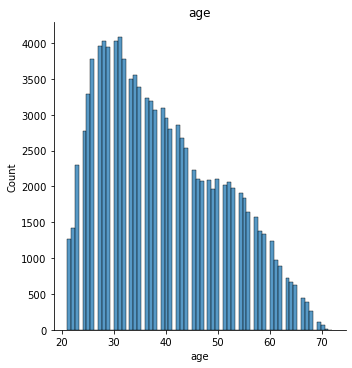

<Figure size 432x288 with 0 Axes>

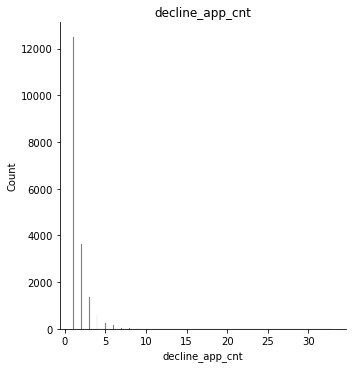

<Figure size 432x288 with 0 Axes>

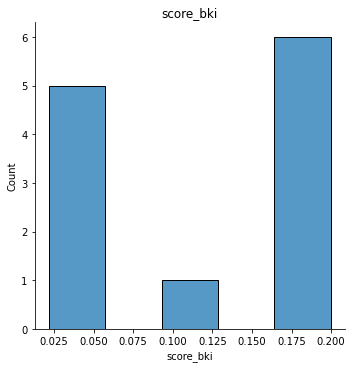

<Figure size 432x288 with 0 Axes>

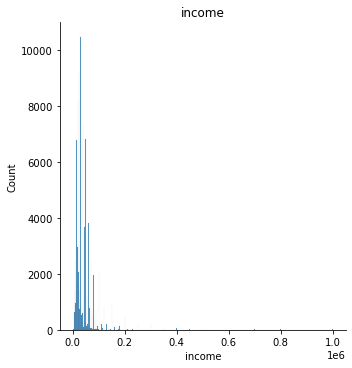

<Figure size 432x288 with 0 Axes>

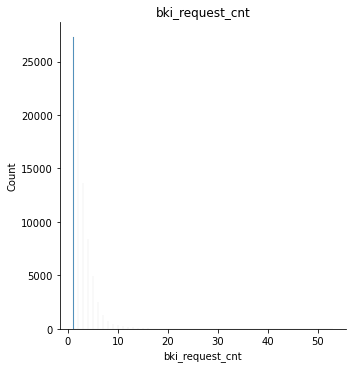

In [13]:
# посмотрим на распределение
for i in num_cols:
    plt.figure()
    sns.displot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

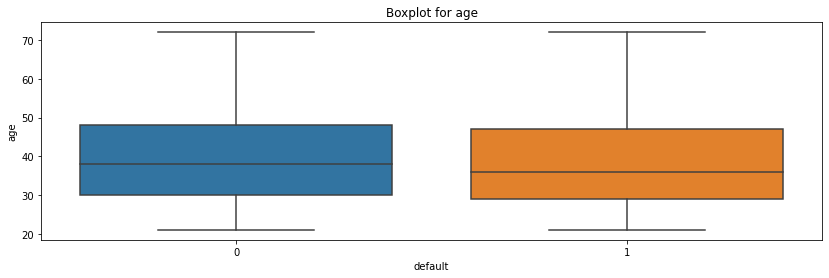

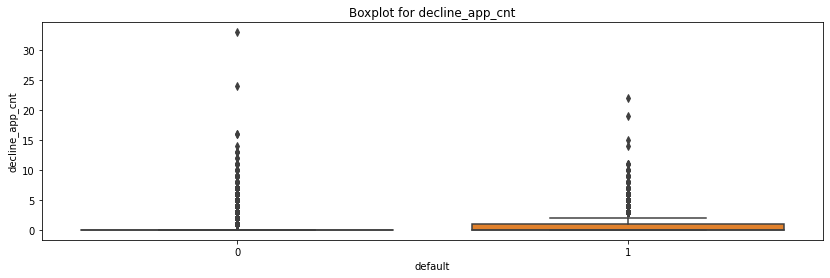

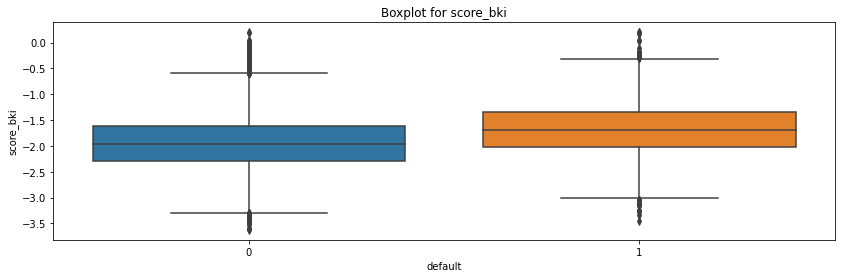

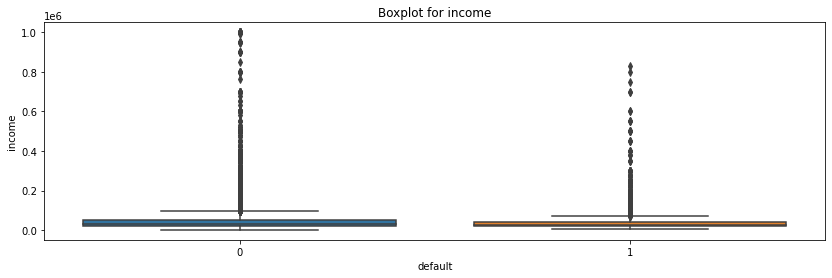

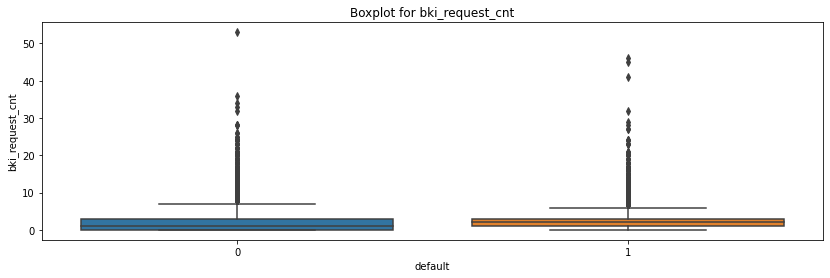

In [14]:
# посмотрим на выбросы
# и распределение целевой переменной между количественными признаками
for col in num_cols:
    boxplot(col)

Краткие выводы:
* дефолт больше характерен для более молодых
* высокий score_bki характерен для дефолта
* рейтинг региона влияет на целевую переменную
* частые запросы в БКИ характерны для менее уверенных клиентов и могут сигнализировать дефолтную ситуацию
* в среднем, более высокий доход свидетельствует о меньшей вероятности дефолта

## Категориальные признаки

Клиенты с более низким уровнем образования чаще подвержены дефолту. В то же время, они чаще берут кредиты.

Чем ниже рейтинг региона, тем чаще возникает дефолт по кредитам. Но это неверно для двух наименее рейтинговых регионов.

Домашний и рабочий адреса распределены схожим образом. Возможно, есть мультиколлинеарность.

Категории sna: ниже категория - меньше дефолтов. First_time - аналогично.

Пропущенные значения:
 478


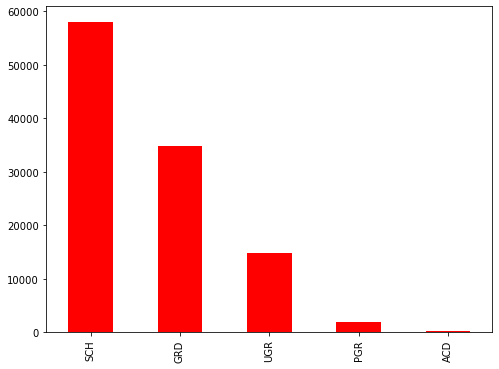

In [15]:
data.education.value_counts().plot(kind="bar",figsize=(8,6),color="r")
print("Пропущенные значения:\n", data.education.isna().sum())

In [16]:
# заполним пропуски наиболее часто встречающимся значением
data.education = data.education.fillna("SCH")

<AxesSubplot:xlabel='education', ylabel='income'>

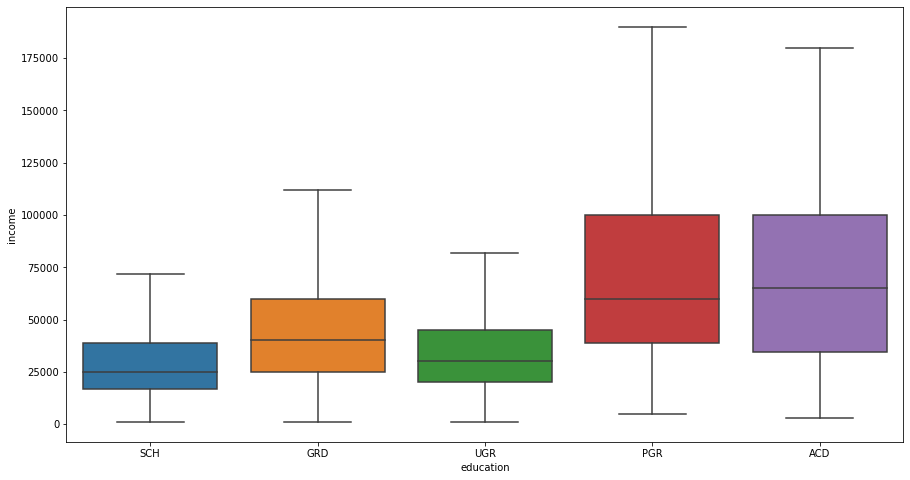

In [17]:
# оценим доход от уровня образования
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="income", data=data, showfliers=False)

<AxesSubplot:xlabel='education', ylabel='region_rating'>

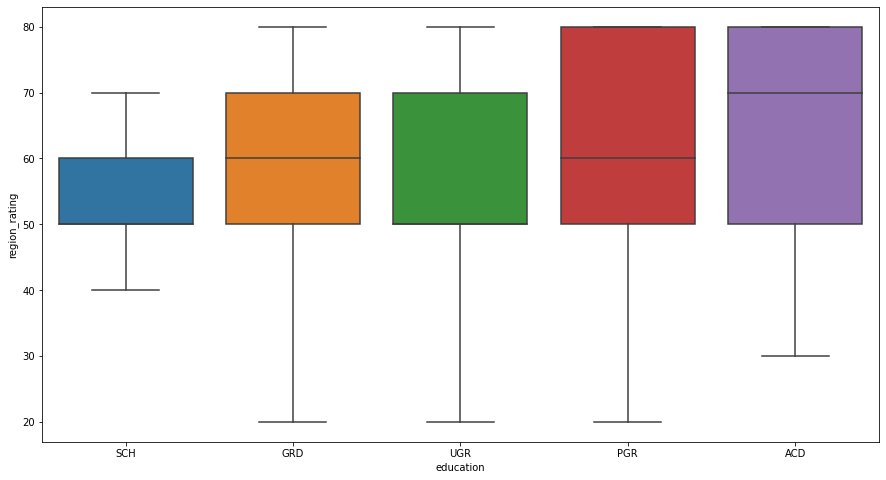

In [18]:
# оценим доход от уровня образования
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="region_rating", data=data, showfliers=False)

Люди с более высоким уровнем образования живут в регионах с более высоким рейтингом. И наоборот.

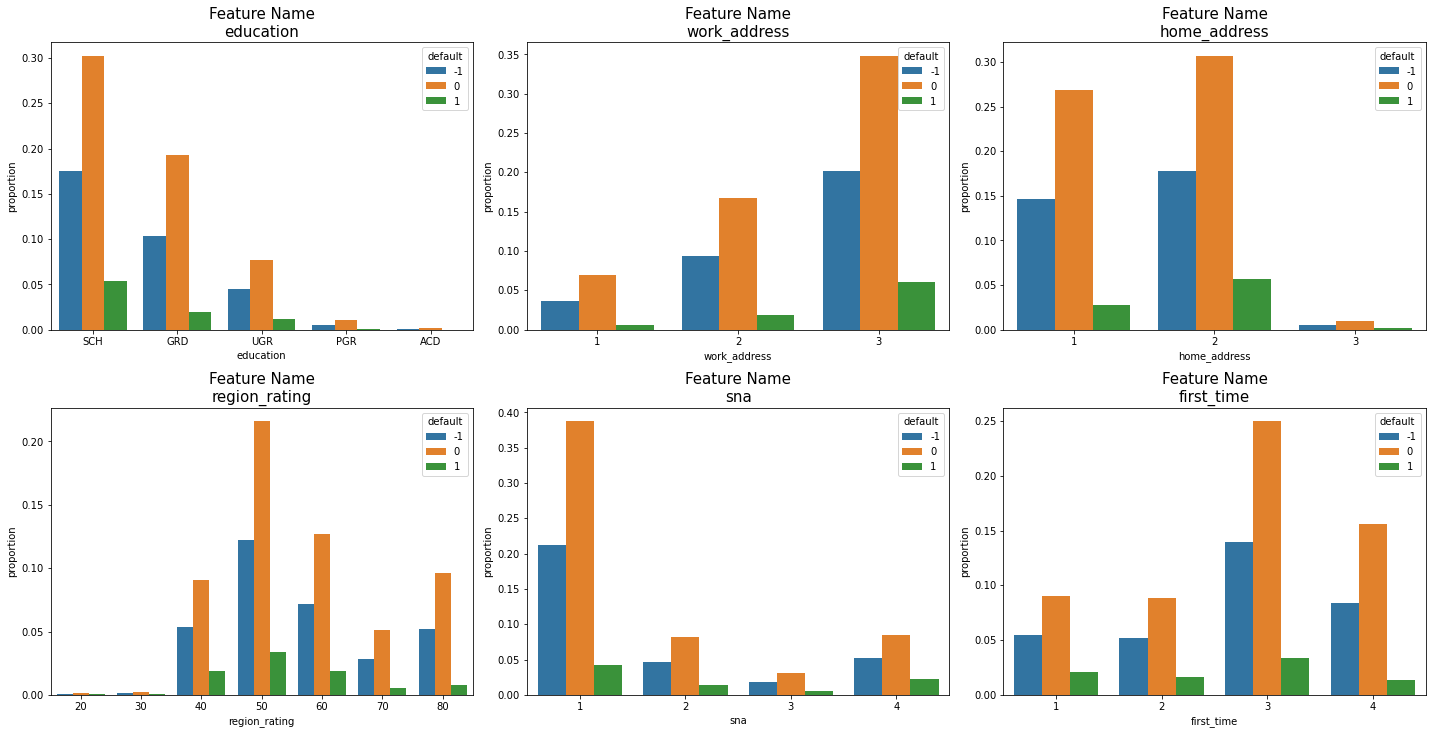

In [19]:
plt.figure(figsize=[20, 20])
i = 1

for k in cat_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=data[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index())
    plt.title('Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

In [20]:
mappc = {}
label_encoder = LabelEncoder()
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col])
    mappc[col] = dict(enumerate(label_encoder.classes_))
    
print(mappc)

{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}, 'work_address': {0: 1, 1: 2, 2: 3}, 'home_address': {0: 1, 1: 2, 2: 3}, 'region_rating': {0: 20, 1: 30, 2: 40, 3: 50, 4: 60, 5: 70, 6: 80}, 'sna': {0: 1, 1: 2, 2: 3, 3: 4}, 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}


## Бинарные признаки

Женщины чаще берут кредиты, чем мужчины. Относительное количество дефолтов при этом практически одинаковое.

Заемщики, у которых есть машина, более надежны. 

Заемщики, у которых иностранный автомобиль, более надежны, чем заемщики с отечественными машинами. Далее попробуем объединить два признака и сделать новый категориальный - не имеет машины, имеет отечественную машину, имеет иностранную машину.

Заемщики с хорошей работой и заграничным паспортом возвращают долг чаще, чем противоположные группы.

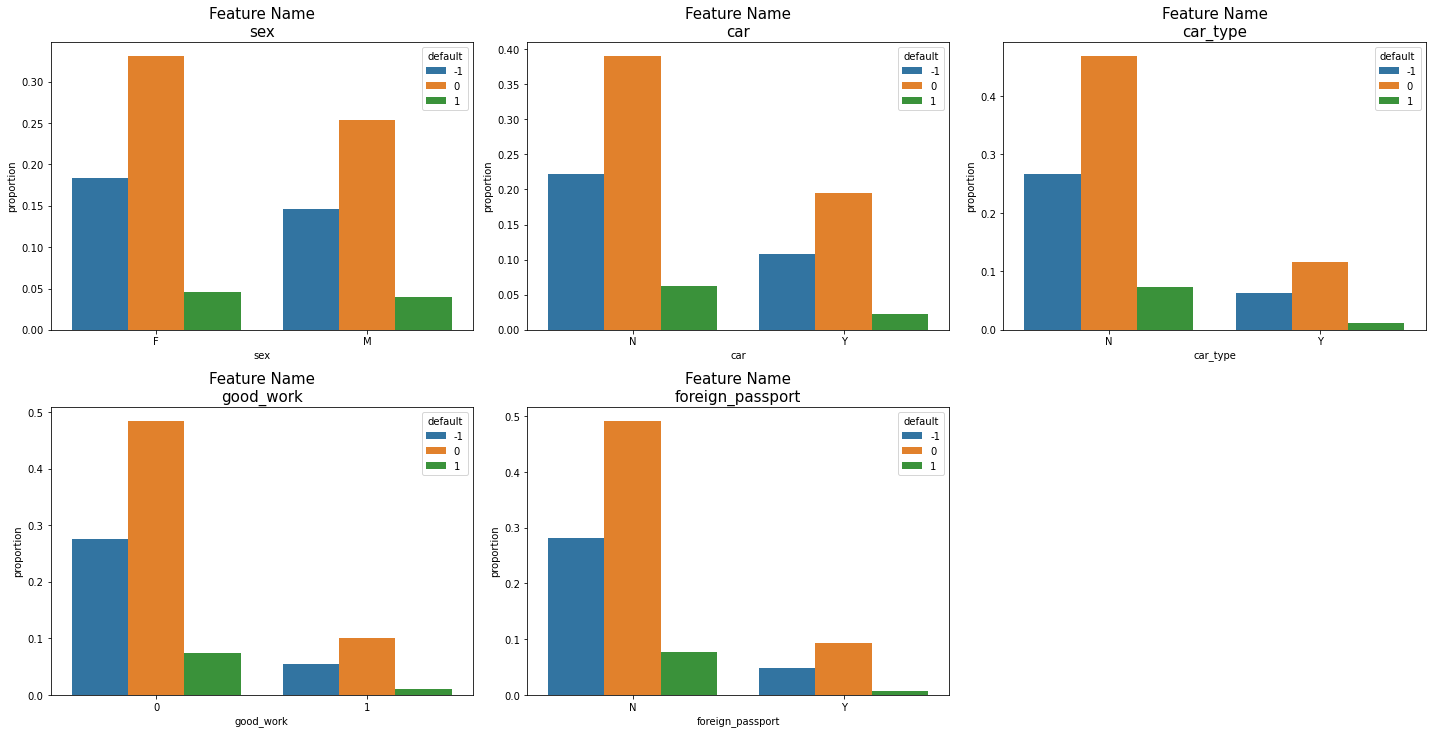

In [21]:
plt.figure(figsize=[20, 20])
i = 1

for k in bin_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k,
                y='proportion',
                hue='default',
                data=data[[k, 'default']].value_counts(
                    normalize=True).rename('proportion').reset_index())
    plt.title('Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

In [22]:
# кодируем признаки

mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])
    mapp[col] = dict(enumerate(label_encoder.classes_))
    
print(mapp)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}


## Корреляционный анализ

Существенная корреляция между домашним адресом и местом работы. Можно попробовать удалить один из признаков.

Сильная корреляция между car, car_type. Отсутствие автомобиля и соответственное отсутствие признака, что автомобиль иностранный. Далее скомбинируем два столбца в один, преобразовав в новый категориальный признак. Так мы уменьшим размерность набора данных, но не потеряем информацию.

Есть довольно сильная обратная зависимость между sna, first_time. Объяснить эти признаки можно попробовать так: чем дольше человек является клиентом банка, тем больше у него отношений с другими клиентами внутри банка (например, поручители) и тем ниже риск дефолта.

Наиболее статистически значимые признаки - Score_bki, decline_app_cnt. Мультиколлинеарность в целом отсутствует, что подтверждается рангом матрицы. Значение определителя позволяет сделать предположение о наличиии обратной матрицы.

<AxesSubplot:>

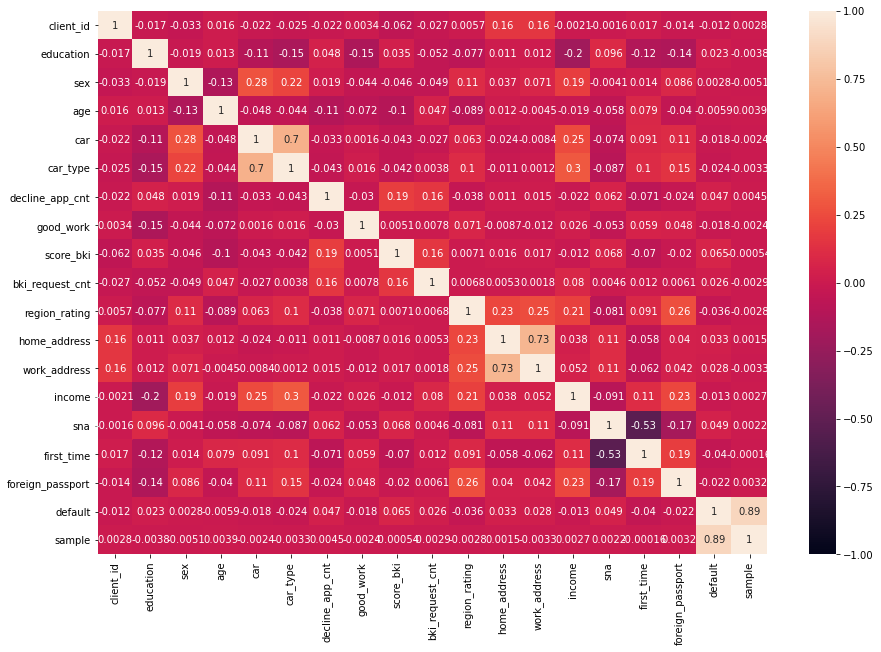

In [23]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot = True)

<AxesSubplot:>

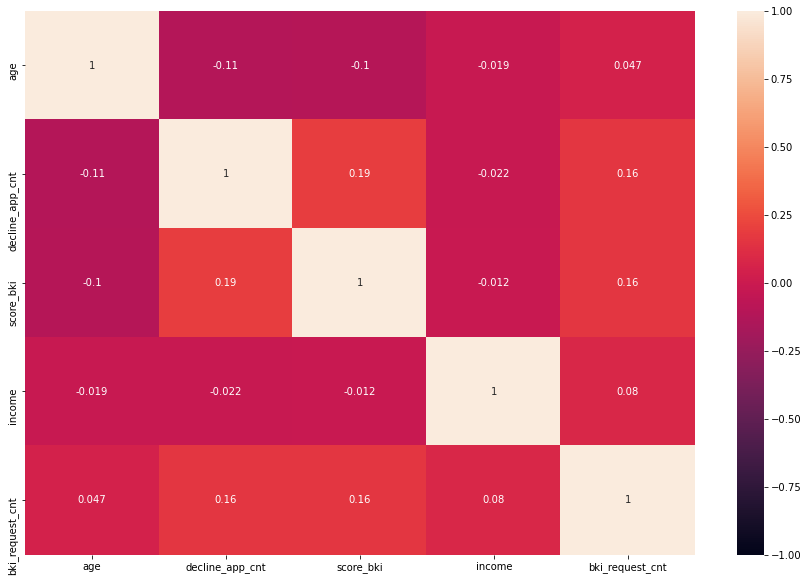

In [24]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[num_cols].corr(), vmin=-1, vmax=1, annot = True)

<AxesSubplot:>

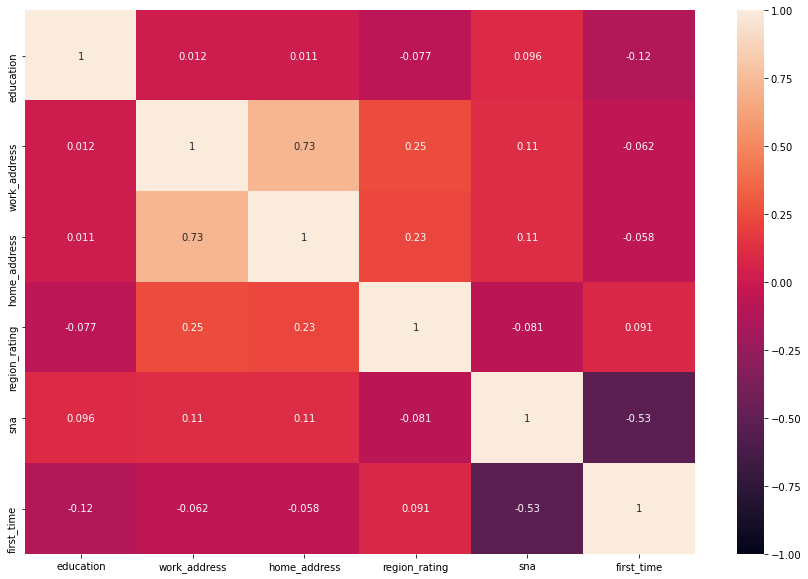

In [25]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[cat_cols].corr(), vmin=-1, vmax=1, annot = True)

<AxesSubplot:>

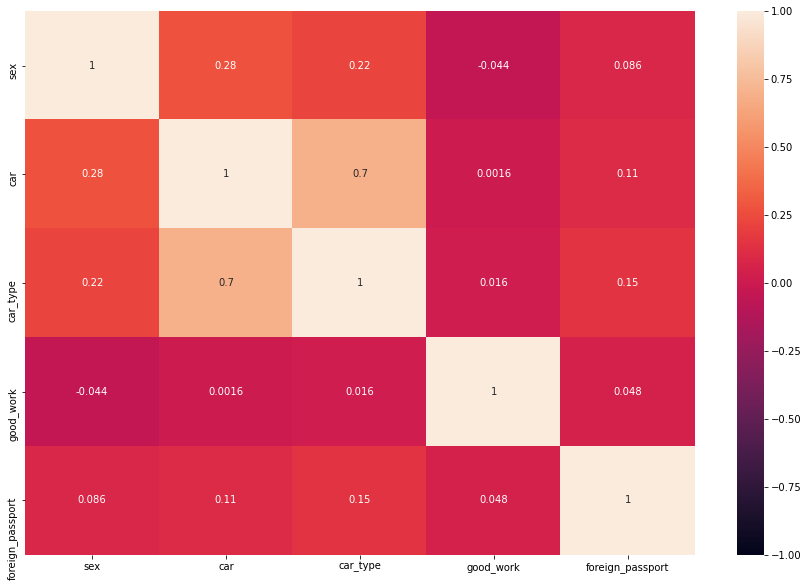

In [26]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[bin_cols].corr(), vmin=-1, vmax=1, annot = True)

## Создание признаков

In [27]:
df = data.copy()

# получим кол-во дней от "начала эпохи" датасета
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')
data_min = min(df['app_date'])
df['days'] = (df['app_date'] - data_min).dt.days.astype('int')
df['day'] = df['app_date'].dt.day
df['month'] = df['app_date'].dt.month

df.drop(['day', 'app_date','month'],  axis = 1, inplace = True)

# средний доход для конкретного возраста
mean_income = df.groupby('age')['income'].mean().to_dict()
df['mean_income_age'] = df['age'].map(mean_income)

# максимальный доход для конкретного возраста
max_income = df.groupby('age')['income'].max().to_dict()
df['max_income_age'] = df['age'].map(max_income)

# минимальный доход для конкретного возраста
min_income = df.groupby('age')['income'].min().to_dict()
df['min_income_age'] = df['age'].map(min_income)

# нормализуем доход
df["normalized_income"] = abs((df.income - df.mean_income_age)/df.max_income_age)
df.drop(['mean_income_age', 'max_income_age'],  axis = 1, inplace = True)

# среднее кол-во запросов в БКИ по конкретному возрасту
mean_bki = df.groupby('age')['bki_request_cnt'].mean().to_dict()
df['mean_requests_age'] = df['age'].map(mean_bki)

# максимальное кол-во запросов в БКИ по конкретному возрасту
max_bki = df.groupby('age')['bki_request_cnt'].max().to_dict()
df['max_requests_age'] = df['age'].map(max_bki)

# нормализуем requests
df["normalized_req"] = abs((df.bki_request_cnt - df.mean_requests_age)/df.max_requests_age)
df.drop(['mean_requests_age', 'max_requests_age'],  axis = 1, inplace = True)

# среднее кол-во запросов в БКИ в зависимости от дохода
mean_bki_inc = df.groupby('income')['bki_request_cnt'].mean().to_dict()
df['mean_requests_income'] = df['income'].map(mean_bki_inc)

# средний доход по региону
mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

df.drop(['income'],  axis = 1, inplace = True)

# сократим размерность матрицы без потери информации
# 0 - нет машины, 1 - есть отечественна машина, 2 - есть иномарка
df['car_comb'] = df['car'] + df['car_type']
df = df.drop(['car', 'car_type'], axis=1)
df['car_comb'] = df['car_comb'].astype('category')

# возраст разделим на четыре категории
df['age_cat'] = 0 # создадим пустой столбец для нового признака
df['age_cat'] = df['age'].apply(lambda x: age_to_cat(x))
df = df.drop('age',axis=1)

label_encoder = LabelEncoder()
df['age_cat'] = label_encoder.fit_transform(df['age_cat'])
    
# Sort out decline_app_cnt and bki_request_cnt by groups:
df['decline_cat'] = df['decline_app_cnt'].apply(lambda x: 4 if x >= 4 else x) 
df['bki_request_cat'] = df['bki_request_cnt'].apply(lambda x: 6 if x >= 6 else x)
df = df.drop('decline_app_cnt',axis=1)
df = df.drop('bki_request_cnt',axis=1)

## Декомпозиция адресов

Как мы установили ранее, home_address and work address обладают сильной корреляцией. Уменьшим размерность матрицы признаков с помощью sklearn.decomposition.

In [28]:
# вытащим два столбца из датасета
data_addresses = df[['work_address', 'home_address']].values

# создадим Scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_addresses)

# У нас два вектора. Сократим до одного, оставив наиболее значимую информацию.
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_address'] = pca_data
df['pca_address'] = df['pca_address'] + 5
df['pca_address'] = df['pca_address'].apply(lambda x: np.log(x) + 1)

# dудалим ненужные столбцы
df = df.drop(['home_address','work_address'],axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   client_id             110148 non-null  int64   
 1   education             110148 non-null  int64   
 2   sex                   110148 non-null  int64   
 3   good_work             110148 non-null  int64   
 4   score_bki             110148 non-null  float64 
 5   region_rating         110148 non-null  int64   
 6   sna                   110148 non-null  int64   
 7   first_time            110148 non-null  int64   
 8   foreign_passport      110148 non-null  int64   
 9   default               110148 non-null  int64   
 10  sample                110148 non-null  int64   
 11  days                  110148 non-null  int64   
 12  min_income_age        110148 non-null  int64   
 13  normalized_income     110148 non-null  float64 
 14  normalized_req        110146 non-nul

In [30]:
# обновим списки признаков в переменных для обработки
num_cols = [
    'score_bki',
    'days',
    'min_income_age',
    'normalized_income',
    'normalized_req',
    'mean_requests_income',
    'mean_income_region',
]
cat_cols = [
    'education',
    'region_rating',
    'sna',
    'first_time',
    'car_comb',
    'age_cat',
    'decline_cat',
    'bki_request_cat',
    'pca_address',
]
bin_cols = [
    'sex',
    'good_work',
    'foreign_passport',
]

## Выбросы и стандартизация

In [31]:
for col in num_cols:
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    
    print("Column: ", col)
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print()

Column:  score_bki
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  Borderline: [-3.299251946250001, -0.5290698762499992].

Column:  days
25%: 33.0, 75%: 89.0, IQR: 56.0,  Borderline: [-51.0, 173.0].

Column:  min_income_age
25%: 2400.0, 75%: 5000.0, IQR: 2600.0,  Borderline: [-1500.0, 8900.0].

Column:  normalized_income
25%: 0.01180008343659645, 75%: 0.03442684580865195, IQR: 0.0226267623720555,  Borderline: [-0.022140060121486803, 0.0683669893667352].

Column:  normalized_req
25%: 0.02791508238276299, 75%: 0.07704498354260636, IQR: 0.04912990115984337,  Borderline: [-0.04577976935700207, 0.15073983528237142].

Column:  mean_requests_income
25%: 1.8568756875687569, 75%: 2.112865035516969, IQR: 0.25598934794821226,  Borderline: [1.4728916656464386, 2.4968490574392876].

Column:  mean_income_region
25%: 35042.57358287987, 75%: 37294.95645651902, IQR: 2252.3828736391515,  Borderline: [31663.999272421144, 40673.530766977754].



In [32]:
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols].values)

dataset = df.copy()

## Статистическая значимость признаков

In [33]:
data_temp = dataset.loc[data['sample'] == 1]

# fix 2 zeros in normalized_req
data_temp = data_temp.fillna(data_temp.mean())

In [34]:
data_temp[num_cols].isna().sum()

score_bki               0
days                    0
min_income_age          0
normalized_income       0
normalized_req          0
mean_requests_income    0
mean_income_region      0
dtype: int64

<AxesSubplot:>

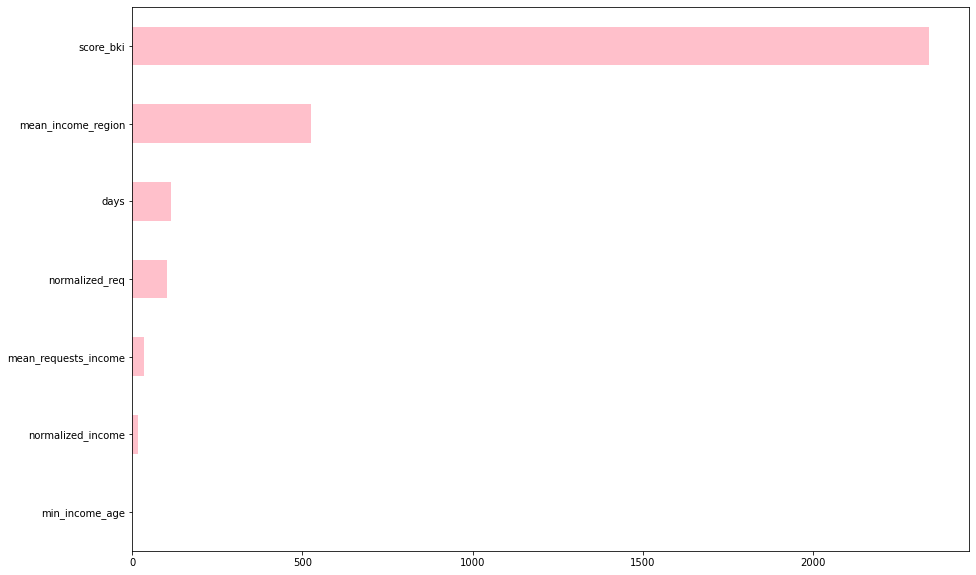

In [35]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind = 'barh', color='pink')

<AxesSubplot:>

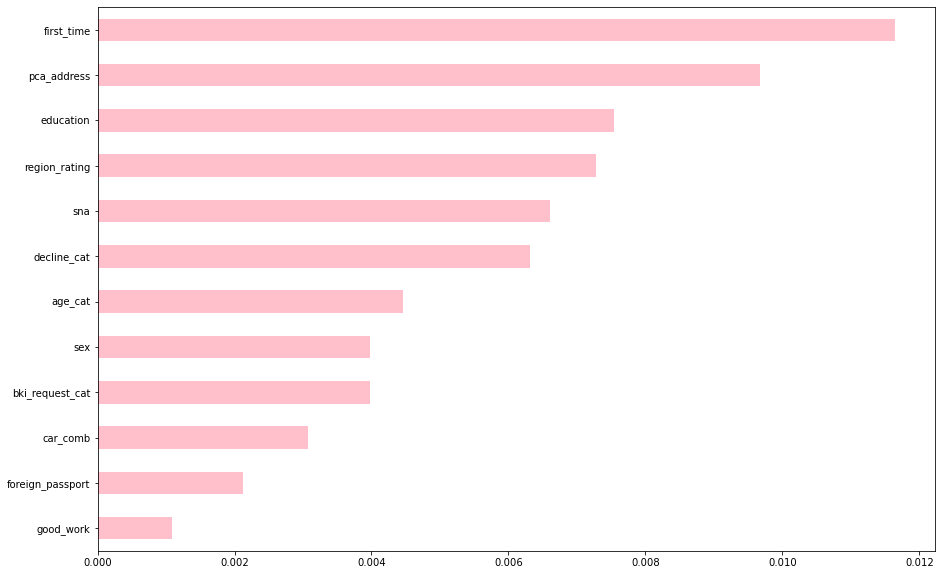

In [36]:
imp_cat = pd.Series(mutual_info_classif(data_temp[bin_cols + cat_cols], data_temp['default'],
                                        discrete_features=False), index=bin_cols+cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', color='pink')

## Кодирование категориальных признаков

In [37]:
df = dataset.copy()

In [38]:
df.isna().sum()

client_id               0
education               0
sex                     0
good_work               0
score_bki               0
region_rating           0
sna                     0
first_time              0
foreign_passport        0
default                 0
sample                  0
days                    0
min_income_age          0
normalized_income       0
normalized_req          2
mean_requests_income    0
mean_income_region      0
car_comb                0
age_cat                 0
decline_cat             0
bki_request_cat         0
pca_address             0
dtype: int64

In [39]:
# fix 2 zeros in normalized_req
df = df.fillna(df.mean())

# One-Hot Encoding
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

## Промежуточные выводы

Бинарные признаки:
* Car и car_type сильно взаимозависимы. Объединены в один признак car_comb с тремя характеристиками.
* Количество должников среди мужчин и женщин примерно одинаковое, но женщины берут кредиты чаще.

Категориальные признаки:
* Люди со слабым образованием возвращают кредиты реже, чем люди с сильным образованием.
* Чем больше отношений у клиента с другими клиентами в банке - тем лучше и меньше просроченных кредитов.
* Люди с более крутым образованием живут в регионах с более высоким рейтингом.
* Чем выше рейтинг региона, тем ниже риск дефолта.
* Имеется корреляция между sna и first_time, Home и work addresses (признак заменен на объединенный посредством PCA).

Numerical:
* score_bki имеет распределение, близкое к нормальному
* В данных есть выбросы. Устранены через преобразование признаков в категориальные, логарифмирование или с использованием Scaler
* Между количественными признаками нет сильных корреляций
* Наличие иномарки коррелирует с уровнем дохода
* Количество связей с другими клиентами банка коррелирует с наличием заграничного паспорта

Наиболее статистически значимые признаки:
* sna
* pca_address (home & work addresses)
* first_time
* score_bki
* mean_income_region

Поскольку мы имеем достаточно много неочевидных корреляций между признаками, стоит попробовать использовать descicion tree models или logistic regressions.

## Моделирование

In [40]:
train_df = df.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_df = df.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [41]:
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED)

In [43]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

## Оценка ROC AUC и других метрик

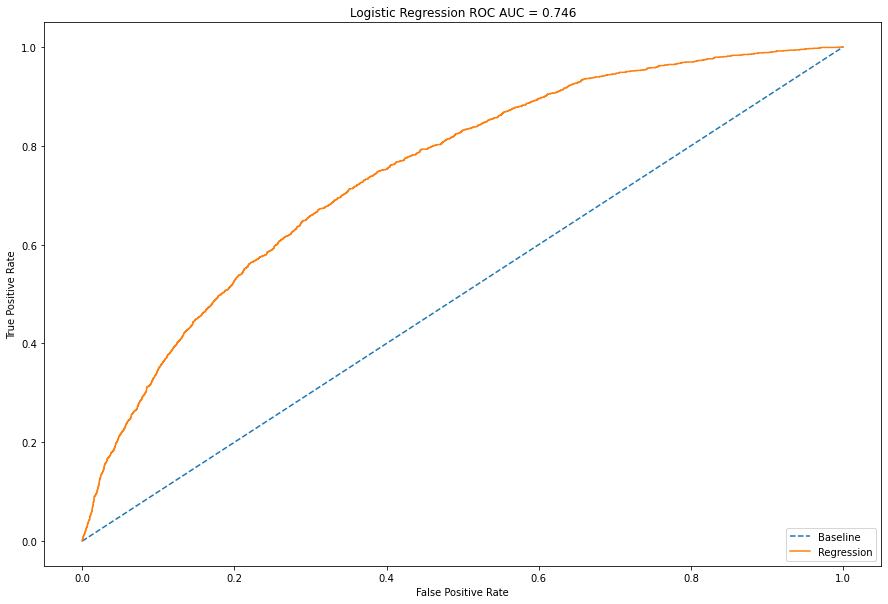

In [44]:
probs = lr.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [45]:
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))

accuracy_score: 0.6715447154471544
precision_score: 0.2270016266040123
recall_score: 0.6874657909140668
f1_score: 0.341304347826087


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

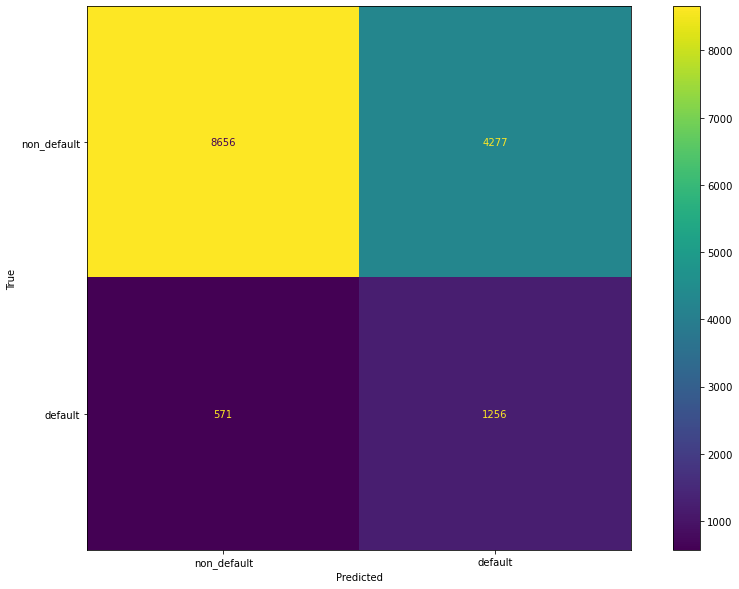

In [46]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default', 'default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

Модель выдает кредиты всем подряд. Необходимо использовать гиперпараметры для ее донастройки.

## Настройка гиперпараметров

In [47]:
train_data = df.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = df.query('sample == 0').drop(['sample', 'client_id'], axis=1)

X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)
y_test = test_data.default.values

In [48]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

In [49]:
xgb = XGBClassifier(learning_rate=0.02,
                    n_estimators=600,
                    objective='binary:logistic',
                    nthread=1, 
                    use_label_encoder=False,
                    eval_metric='logloss')

In [50]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds,
                      shuffle=True,
                      random_state=RANDOM_SEED)

random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='roc_auc',
                                   n_jobs=4,
                                   cv=skf.split(X_train, y_train),
                                   verbose=3,
                                   random_state=RANDOM_SEED)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f90c1e67040>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_chi...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                   

In [51]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' %
      (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results.csv', index=False)


 All results:
{'mean_fit_time': array([39.31620574, 37.70339529, 52.37932165, 37.05852556, 45.32979536]), 'std_fit_time': array([0.5357474 , 2.25528672, 0.53763999, 0.08612187, 0.74427955]), 'mean_score_time': array([0.17702071, 0.1294922 , 0.14376672, 0.1341548 , 0.15782237]), 'std_score_time': array([0.00131927, 0.00487593, 0.00242192, 0.00193885, 0.0107772 ]), 'param_subsample': masked_array(data=[0.8, 1.0, 0.8, 0.6, 0.6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10, 1, 10, 10, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[4, 3, 3, 3, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[1.5, 2, 5, 1, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
     

In [52]:
y_pred = random_search.predict_proba(X_test)
results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})
results_df.to_csv('submission.csv', index=False)
results_df

,client_id,default
0,74835,0.033554
1,17527,0.270057
2,75683,0.069800
3,26883,0.074686
4,28862,0.019581
...,...,...
36344,83775,0.343928
36345,106254,0.024010
36346,81852,0.344839
36347,1971,0.279008


## Выводы

После обработки датасета и добавления новых признаков была сгенерирована базовая модель логистической регрессии, которая показала ROC AUC > 0.74, а также accuracy 0.67, precision 0.227, recall 0.687 и f1_score 0.34.

Модель была донастроена с применением XGBoostClassifier и подбором параметров через RandomizedSearchCV.